## WIFI encrypted CLASSIFIER

A machine-learning classifier able to dis6nguish what kind of ac6vity a user is performing with his/her smartphone/laptop by sniffing traffic in monitor mode.

a. Sniff traffic in monitor mode from a known MAC address 

b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

a. Sniff traffic in monitor mode from a known MAC address 

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display

def create_sampling(initTime, sniff):
    treshold = sniff["Time"].min() #take minimun timestamp
    W = 2 #secconds
    return math.floor( (initTime - treshold)/W )

def load_and_sample_data(csv):
    # read each X seconds, take statistics
    # ((wlan.sa == aa:3a:0e:b6:ed:12  or wlan.da == aa:3a:0e:b6:ed:12 ) ) && (wlan.fc.type_subtype == 0x0028)
    # import csv
    sniff = pd.read_csv('./csvs/{}_completed.csv'.format(csv))

    sniff["sample_no"] = sniff["Time"].apply(lambda x:create_sampling(x,sniff))
    
    return sniff

def get_stats(data, label):
    process_data = pd.DataFrame()
    data['IAT'] = data["Time"].diff()
    display(data.head(30))
    groupedBySample = data.groupby("sample_no")

    # avrg and variance packet size
    process_data["avrg_len"] = groupedBySample["Length"].mean()
    process_data["var_len"] = groupedBySample["Length"].var(ddof=0)

    # avrg and variance inter-arrival-times
    process_data["avrg_IAT"] = groupedBySample["IAT"].mean()
    process_data["var_IAT"] = groupedBySample["IAT"].var(ddof=0)

    # packets count and down up link count
    SRC_MAC = 'aa:3a:0e:b6:ed:12'
    count = groupedBySample.size()
    process_data["count"] = count
    upload_count = data.loc[ data["Source"] == SRC_MAC ].groupby("sample_no").size() # get only uplink packets
    process_data["upload_percentage"] = upload_count/count


     # count of QoS types
    qos_types_subtypes = [
        "Best Effort (Best Effort)",
        "Background (Background)",
        "Spare (Background)",
        "Excellent Effort (Best Effort)",
        "Controlled Load (Video)",
        "Video (Video)",
        "Voice (Voice)",
        "Network Control (Voice)"
    ]

    qos_columns = []
    for i,type in enumerate(qos_types_subtypes):
        column = "qos_type{}".format(i)
        qos_columns = [*qos_columns, column]
        process_data[column] = data.loc[ data["wlan.qos.priority"] == type ].groupby("sample_no").size()
        process_data[column] = process_data[column].fillna(0)
        process_data[column] = process_data[column] / count

    return process_data.reset_index()



b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

In [70]:
# create X
#   limpiar campos 
#   obtener solo del objective mac
#       original source (SA), final destination (DA), and the immediate sending/receiving systems (TA/RA)
#   obtener estatistiticas

data = [["browsing", "browsing"],["call1","online_streaming"],["call2","online_streaming"],["idle","idle"],["youtube","youtube"]]
final_set = pd.DataFrame()
for i,[csv, label] in enumerate(data):
    samples = load_and_sample_data(csv)
    stats = get_stats(samples, label)

    #label set
    stats["gt"] = stats["sample_no"].apply(lambda x: label)
    final_set = pd.concat([final_set,stats])
    
final_set.to_csv('test.csv')



,No.,Time,Source,Destination,Protocol,Length,Info,wlan.qos.priority,sample_no,IAT
0,1,0.000000,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=954, FN=0, Flags=....",NaN,0,NaN
1,2,0.000022,aa:3a:0e:b6:ed:12,IPv4mcast_fb,802.11,127,"QoS Data, SN=21, FN=0, Flags=.p.....TC",Network Control (Voice),0,0.000022
2,3,0.000042,aa:3a:0e:b6:ed:12,IPv4mcast_fb,802.11,127,"QoS Data, SN=21, FN=0, Flags=.p..R..TC",Network Control (Voice),0,0.000020
3,4,0.000061,aa:3a:0e:b6:ed:12,IPv4mcast_fb,802.11,127,"QoS Data, SN=21, FN=0, Flags=.p..R..TC",Network Control (Voice),0,0.000018
4,5,0.000084,aa:3a:0e:b6:ed:12,IPv4mcast_fb,802.11,127,"QoS Data, SN=21, FN=0, Flags=.p..R..TC",Network Control (Voice),0,0.000024
5,6,0.206276,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=958, FN=0, Flags=....",NaN,0,0.206192
6,7,0.206296,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=958, FN=0, Flags=....",NaN,0,0.000020
7,8,0.206308,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=958, FN=0, Flags=....",NaN,0,0.000012
8,9,0.206320,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=958, FN=0, Flags=....",NaN,0,0.000012
9,10,0.206331,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=958, FN=0, Flags=....",NaN,0,0.000011


,avrg_len,var_len,avrg_IAT,var_IAT,count,upload_percentage,qos_type0,qos_type1,qos_type2,qos_type3,qos_type4,qos_type5,qos_type6,qos_type7
sample_no,,,,,,,,,,,,,,
0,90.600000,1428.773333,0.132525,0.052617,15,1.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.000000,0.266667
1,147.000000,0.000000,0.598092,0.000000,1,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,66.000000,0.000000,3.640907,0.000000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
5,75.000000,405.000000,0.939007,3.775170,6,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000
6,209.312500,61531.714844,0.140117,0.133174,16,1.000000,0.625000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
7,219.309524,27037.189909,0.023519,0.001915,84,0.988095,0.880952,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
8,243.623377,58960.754259,0.017542,0.002849,77,1.000000,0.935065,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
9,367.843478,452861.618979,0.011623,0.006267,230,0.930435,0.843478,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10,218.944724,115236.403980,0.010045,0.000944,199,0.989950,0.914573,0.0,0.0,0.0,0.0,0.0,0.005025,0.000000


,No.,Time,Source,Destination,Protocol,Length,Info,wlan.qos.priority,sample_no,IAT
0,1,0.000000,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:8f,802.11,169,"QoS Data, SN=405, FN=0, Flags=.p.....TC",Best Effort (Best Effort),0,NaN
1,2,2.458684,aa:3a:0e:b6:ed:12,IPv4mcast_fb,802.11,179,"Data, SN=3531, FN=0, Flags=.p....F.C",NaN,1,2.458684
2,3,22.936823,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2286, FN=0, Flags=...",NaN,11,20.478139
3,4,22.953609,aa:3a:0e:b6:ed:12,IPv4mcast_7f:ff:fa,802.11,243,"Data, SN=3787, FN=0, Flags=.p....F.C",NaN,11,0.016785
4,5,23.756203,aa:3a:0e:b6:ed:12,IPv6mcast_ff:b0:bc:10,802.11,162,"Data, SN=3800, FN=0, Flags=.p....F.C",NaN,11,0.802595
5,6,27.029968,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2296, FN=0, Flags=...",NaN,13,3.273765
6,7,27.234104,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2300, FN=0, Flags=...",NaN,13,0.204136
7,8,27.442526,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2304, FN=0, Flags=...",NaN,13,0.208422
8,9,27.644480,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2308, FN=0, Flags=...",NaN,13,0.201954
9,10,28.258549,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2312, FN=0, Flags=...",NaN,14,0.614069


,avrg_len,var_len,avrg_IAT,var_IAT,count,upload_percentage,qos_type0,qos_type1,qos_type2,qos_type3,qos_type4,qos_type5,qos_type6,qos_type7
sample_no,,,,,,,,,,,,,,
0,169.000000,0.000000,NaN,NaN,1,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,179.000000,0.000000,2.458684,0.000000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
11,157.000000,5234.000000,7.099173,89.601284,3,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
13,66.000000,0.000000,0.972069,1.765940,4,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
14,280.111111,127466.765432,0.250620,0.109739,9,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333
15,542.269231,201616.042899,0.078570,0.015367,26,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.653846
16,461.434783,188458.680529,0.080197,0.013451,23,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.565217
17,539.307692,192464.879684,0.052565,0.008818,39,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.641026
18,526.102564,200103.374096,0.052418,0.006852,39,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.615385


,No.,Time,Source,Destination,Protocol,Length,Info,wlan.qos.priority,sample_no,IAT
0,1,0.000000,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:8f,802.11,169,"QoS Data, SN=405, FN=0, Flags=.p.....TC",Best Effort (Best Effort),0,NaN
1,2,2.458684,aa:3a:0e:b6:ed:12,IPv4mcast_fb,802.11,179,"Data, SN=3531, FN=0, Flags=.p....F.C",NaN,1,2.458684
2,3,22.936823,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2286, FN=0, Flags=...",NaN,11,20.478139
3,4,22.953609,aa:3a:0e:b6:ed:12,IPv4mcast_7f:ff:fa,802.11,243,"Data, SN=3787, FN=0, Flags=.p....F.C",NaN,11,0.016785
4,5,23.756203,aa:3a:0e:b6:ed:12,IPv6mcast_ff:b0:bc:10,802.11,162,"Data, SN=3800, FN=0, Flags=.p....F.C",NaN,11,0.802595
5,6,27.029968,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2296, FN=0, Flags=...",NaN,13,3.273765
6,7,27.234104,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2300, FN=0, Flags=...",NaN,13,0.204136
7,8,27.442526,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2304, FN=0, Flags=...",NaN,13,0.208422
8,9,27.644480,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2308, FN=0, Flags=...",NaN,13,0.201954
9,10,28.258549,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=2312, FN=0, Flags=...",NaN,14,0.614069


,avrg_len,var_len,avrg_IAT,var_IAT,count,upload_percentage,qos_type0,qos_type1,qos_type2,qos_type3,qos_type4,qos_type5,qos_type6,qos_type7
sample_no,,,,,,,,,,,,,,
0,169.000000,0.000000,NaN,NaN,1,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,179.000000,0.000000,2.458684,0.000000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
11,157.000000,5234.000000,7.099173,89.601284,3,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
13,66.000000,0.000000,0.972069,1.765940,4,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
14,280.111111,127466.765432,0.250620,0.109739,9,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333
15,542.269231,201616.042899,0.078570,0.015367,26,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.653846
16,461.434783,188458.680529,0.080197,0.013451,23,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.565217
17,539.307692,192464.879684,0.052565,0.008818,39,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.641026
18,526.102564,200103.374096,0.052418,0.006852,39,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.615385


,No.,Time,Source,Destination,Protocol,Length,Info,wlan.qos.priority,sample_no,IAT
0,1,0.000000,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,141,"Probe Request, SN=0, FN=0, Flags=........C, SS...",NaN,0,NaN
1,2,0.013117,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,141,"Probe Request, SN=1, FN=0, Flags=........C, SS...",NaN,0,0.013117
2,3,0.013162,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,141,"Probe Request, SN=1, FN=0, Flags=....R...C, SS...",NaN,0,0.000045
3,4,0.022919,5a:ef:68:0f:bd:90,aa:3a:0e:b6:ed:12,802.11,218,"Probe Response, SN=1349, FN=0, Flags=........C...",NaN,0,0.009756
4,5,0.031832,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,72,"Authentication, SN=2, FN=0, Flags=....R...C",NaN,0,0.008913
5,6,0.049801,aa:3a:0e:b6:ed:12,Broadcast,802.11,88,"Data, SN=1353, FN=0, Flags=.p....F.C",NaN,0,0.017969
6,7,0.066130,5a:ef:68:0f:bd:90,aa:3a:0e:b6:ed:12,802.11,218,"Probe Response, SN=1354, FN=0, Flags=........C...",NaN,0,0.016329
7,8,0.069514,5a:ef:68:0f:bd:90,aa:3a:0e:b6:ed:12,802.11,72,"Authentication, SN=1355, FN=0, Flags=........C",NaN,0,0.003384
8,9,0.143438,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,220,"Association Request, SN=3, FN=0, Flags=..........",NaN,0,0.073924
9,10,0.169607,5a:ef:68:0f:bd:90,aa:3a:0e:b6:ed:12,EAPOL,175,Key (Message 1 of 4),Network Control (Voice),0,0.026169


,avrg_len,var_len,avrg_IAT,var_IAT,count,upload_percentage,qos_type0,qos_type1,qos_type2,qos_type3,qos_type4,qos_type5,qos_type6,qos_type7
sample_no,,,,,,,,,,,,,,
0,172.421053,12094.278855,0.035013,0.009708,57,0.859649,0.438596,0.0,0.0,0.0,0.0,0.0,0.087719,0.070175
1,207.577465,49075.835549,0.014054,0.001169,142,0.971831,0.619718,0.0,0.0,0.0,0.0,0.0,0.000000,0.035211
2,157.000000,2573.304348,0.043330,0.022164,46,1.000000,0.826087,0.0,0.0,0.0,0.0,0.0,0.000000,0.043478
3,115.189189,2573.180424,0.055249,0.006190,37,0.945946,0.108108,0.0,0.0,0.0,0.0,0.0,0.054054,0.081081
4,124.533333,3850.115556,0.133085,0.063247,15,1.000000,0.133333,0.0,0.0,0.0,0.0,0.0,0.000000,0.200000
5,107.142857,1340.693878,0.107716,0.010649,7,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857
6,228.686869,65531.750434,0.032635,0.020128,99,1.000000,0.838384,0.0,0.0,0.0,0.0,0.0,0.000000,0.040404
7,191.690476,51974.356576,0.037618,0.006108,42,0.904762,0.571429,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
8,130.250000,2562.937500,0.140831,0.078930,16,0.875000,0.187500,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


,No.,Time,Source,Destination,Protocol,Length,Info,wlan.qos.priority,sample_no,IAT
0,1,0.000000,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,NaN
1,2,0.000009,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000009
2,3,0.000011,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000002
3,4,0.000013,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000002
4,5,0.000018,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000005
5,6,0.000020,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000002
6,7,0.003506,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.003485
7,8,0.003550,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000044
8,9,0.003553,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000003
9,10,0.003555,aa:3a:0e:b6:ed:12,5a:ef:68:0f:bd:90,802.11,66,"Null function (No data), SN=367, FN=0, Flags=....",NaN,0,0.000002


,avrg_len,var_len,avrg_IAT,var_IAT,count,upload_percentage,qos_type0,qos_type1,qos_type2,qos_type3,qos_type4,qos_type5,qos_type6,qos_type7
sample_no,,,,,,,,,,,,,,
0,188.857923,9.955843e+04,0.010289,0.001029,183,1.000000,0.005464,0.0,0.0,0.0,0.437158,0.0,0.000000,0.0
1,239.272727,1.844300e+05,0.023284,0.007724,88,1.000000,0.000000,0.0,0.0,0.0,0.215909,0.0,0.000000,0.0
2,99.023077,2.805576e+03,0.015798,0.001540,130,1.000000,0.023077,0.0,0.0,0.0,0.261538,0.0,0.000000,0.0
3,119.360000,4.222859e+03,0.011487,0.000619,175,1.000000,0.074286,0.0,0.0,0.0,0.337143,0.0,0.000000,0.0
4,245.178988,2.699773e+05,0.007833,0.000225,257,0.953307,0.042802,0.0,0.0,0.0,0.513619,0.0,0.000000,0.0
5,567.883991,8.611634e+05,0.004641,0.000067,431,0.842227,0.160093,0.0,0.0,0.0,0.498840,0.0,0.000000,0.0
6,627.285714,1.005348e+06,0.005601,0.000134,357,0.792717,0.235294,0.0,0.0,0.0,0.428571,0.0,0.000000,0.0
7,232.146739,1.721808e+05,0.005312,0.000128,368,0.986413,0.239130,0.0,0.0,0.0,0.230978,0.0,0.000000,0.0
8,433.232919,5.836782e+05,0.006354,0.000417,322,0.903727,0.310559,0.0,0.0,0.0,0.357143,0.0,0.000000,0.0


c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

,sample_no,avrg_len,var_len,avrg_IAT,var_IAT,count,upload_percentage,qos_type0,qos_type1,qos_type2,qos_type3,qos_type4,qos_type5,qos_type6,qos_type7,gt
0,0,90.600000,1428.773333,0.132525,0.052617,15,1.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.000000,0.266667,browsing
1,1,147.000000,0.000000,0.598092,0.000000,1,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,browsing
2,3,66.000000,0.000000,3.640907,0.000000,1,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,browsing
3,5,75.000000,405.000000,0.939007,3.775170,6,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,browsing
4,6,209.312500,61531.714844,0.140117,0.133174,16,1.000000,0.625000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,browsing
5,7,219.309524,27037.189909,0.023519,0.001915,84,0.988095,0.880952,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,browsing
6,8,243.623377,58960.754259,0.017542,0.002849,77,1.000000,0.935065,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,browsing
7,9,367.843478,452861.618979,0.011623,0.006267,230,0.930435,0.843478,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,browsing
8,10,218.944724,115236.403980,0.010045,0.000944,199,0.989950,0.914573,0.0,0.0,0.0,0.0,0.0,0.005025,0.000000,browsing
9,11,286.166667,196199.003868,0.004263,0.000360,474,0.978903,0.955696,0.0,0.0,0.0,0.0,0.0,0.002110,0.000000,browsing


0.7181303116147308
0.7181303116147308
0.7464589235127479
0.7422096317280453


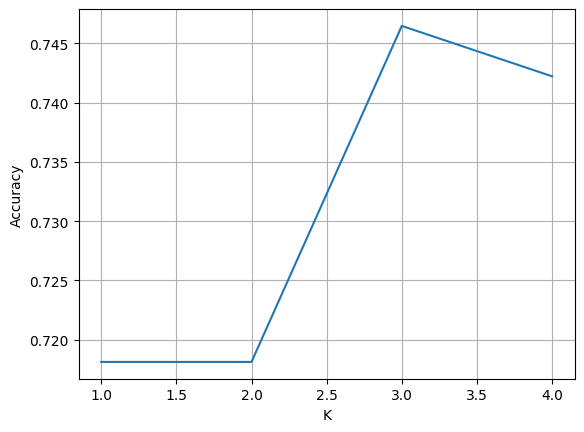

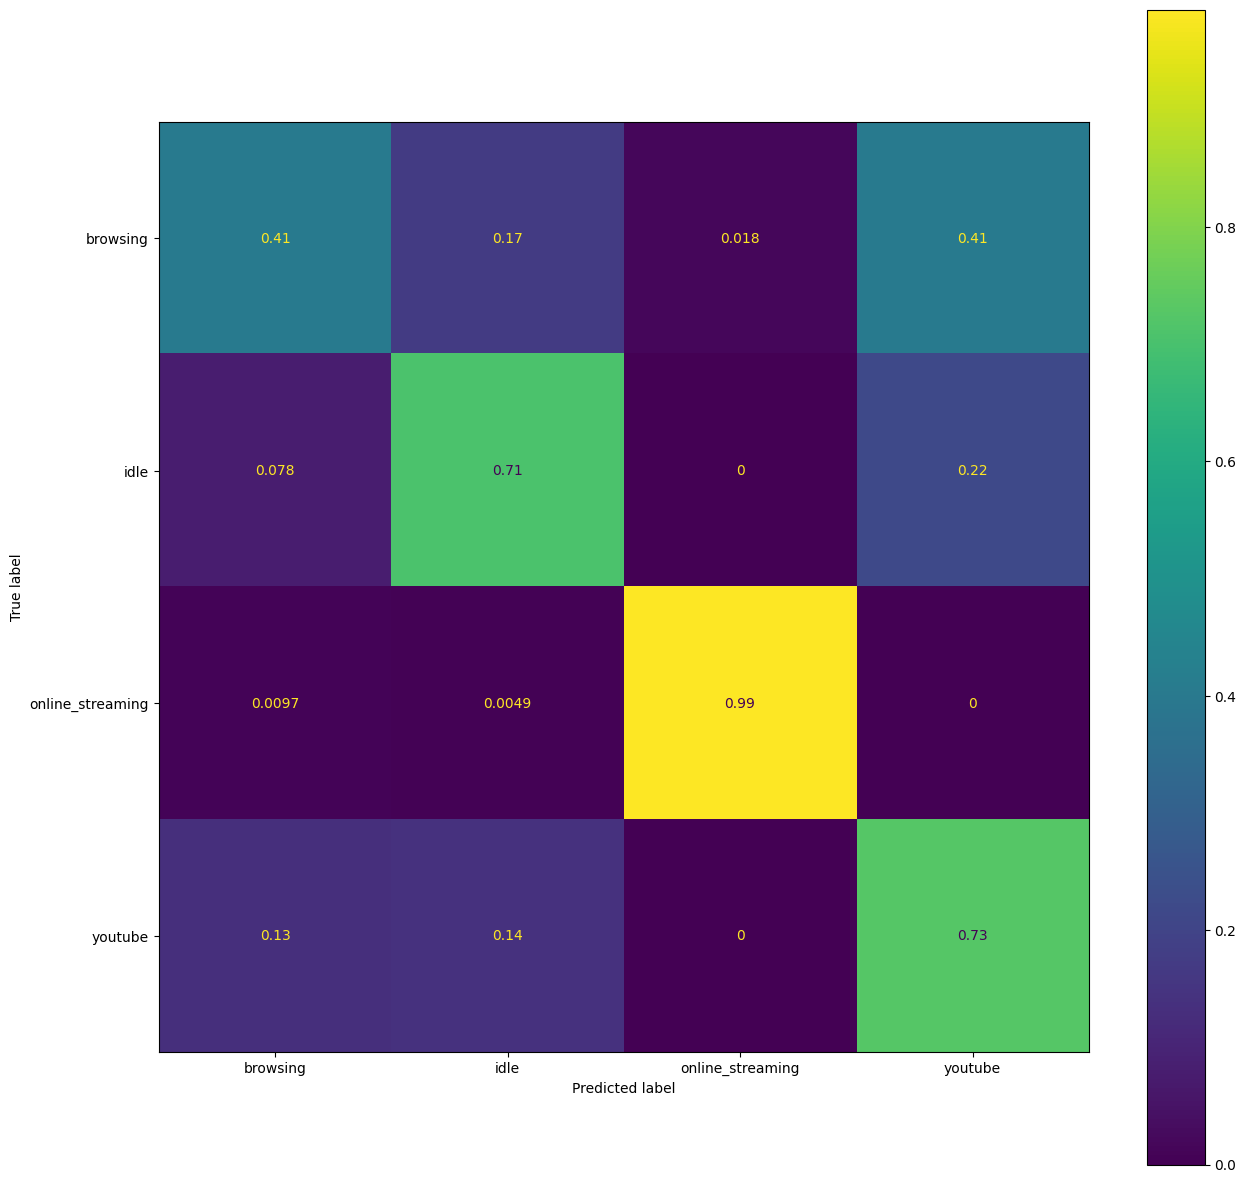

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

scaler = StandardScaler()

X = final_set.dropna()
Y = X["gt"]
X = X.drop('gt',axis=1)

X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.5)

ACCURACY = []
for k in range(1,5):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  print(accuracy)

fig = plt.figure();
plt.plot(range(1,5),ACCURACY);
plt.grid(visible=True);
plt.xlabel('K');
plt.ylabel('Accuracy');

bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')


